In [1]:
import pandas as pd
import numpy as np
import os
#import shutil
import matplotlib.pyplot as plt
#from sklearn.preprocessing import quantile_transform
import itertools
from scipy.stats import linregress
from scipy.stats import spearmanr
from itertools import combinations
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
# read in big bac csv file
big = pd.read_csv("/ix/hpark/Jie/LMM/microbiomap_expr.csv") 
# for big dataset, make rownames
big = big.iloc[:, 1:]           # Step 1: remove the first column
big.index = big.iloc[:, 0]      # Step 2: set the new first column as index
big = big.iloc[:, 1:]           # Step 3: drop that column from the data
print(big.iloc[:6, :6])

                 PRJDB10485_DRR243823  PRJDB10485_DRR243824  \
Genus                                                         
Acidaminococcus                     0                     0   
Actinomyces                         0                     0   
Acutalibacter                       0                     8   
Adlercreutzia                     481                   435   
Agathobaculum                       0                    46   
Akkermansia                         0                  1433   

                 PRJDB10485_DRR243825  PRJDB10485_DRR243826  \
Genus                                                         
Acidaminococcus                   0.0                   0.0   
Actinomyces                       0.0                   0.0   
Acutalibacter                     0.0                   0.0   
Adlercreutzia                     0.0                   0.0   
Agathobaculum                     0.0                   2.0   
Akkermansia                    1809.0                 

In [3]:
# read in small bac file
small = pd.read_csv("/ix/hpark/Jie/LMM/clinical_expr.csv") 
# for small dataset, make rownames
small = small.iloc[:, 1:]           # Step 1: remove the first column
small.index = small.iloc[:, 0]      # Step 2: set the new first column as index
small = small.iloc[:, 1:]           # Step 3: drop that column from the data
print(small.iloc[:6, :6])

                 PD1SS17052dna201907dbDec22  PD117Pittsdna201907dbDec22  \
Genus                                                                     
Acidaminococcus                0.000000e+00                8.808750e+03   
Actinomyces                    0.000000e+00                1.309750e+03   
Acutalibacter                  6.045500e+04                2.555900e+05   
Adlercreutzia                  1.159386e+05                6.518691e+06   
Agathobaculum                  1.000702e+06                7.592119e+06   
Akkermansia                    3.563782e+07                4.286500e+03   

                 PD1SS17005dna201907dbDec22  PD1TPF1820dna201907dbDec22  \
Genus                                                                     
Acidaminococcus                9.027500e+02                1.774998e+07   
Actinomyces                    0.000000e+00                5.253875e+04   
Acutalibacter                  2.465350e+06                1.093250e+05   
Adlercreutzia           

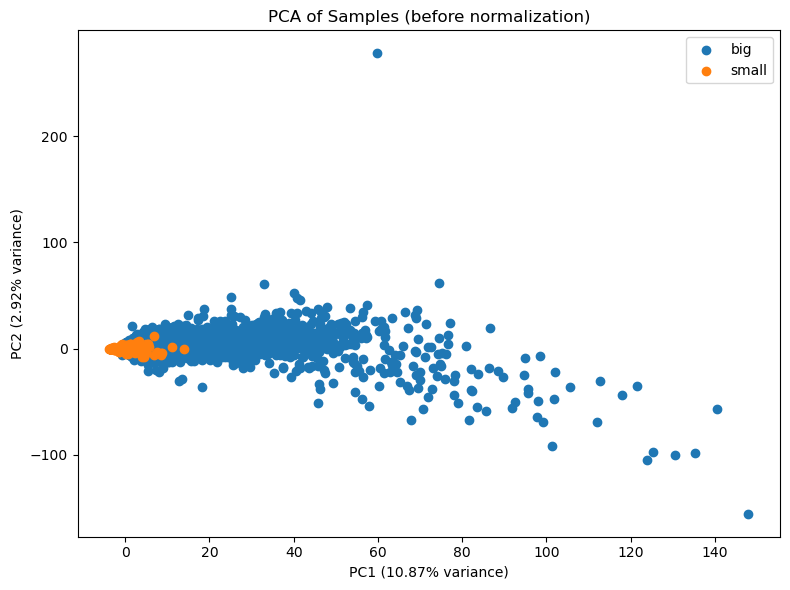

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Scale data
scaler = StandardScaler()
big_scaled = scaler.fit_transform(big.T)
small_scaled = scaler.fit_transform(small.T)

# PCA on big dataset (used for variance display)
pca = PCA(n_components=2)
pca_big = pca.fit_transform(big_scaled)
pc1_var = pca.explained_variance_ratio_[0] * 100
pc2_var = pca.explained_variance_ratio_[1] * 100

# PCA on small dataset (reinitialize PCA)
pca_small = PCA(n_components=2)
pca_small = pca_small.fit_transform(small_scaled)

# Plot
plt.figure(figsize=(8,6))
plt.scatter(pca_big[:, 0], pca_big[:, 1], label='big')
plt.scatter(pca_small[:, 0], pca_small[:, 1], label='small')
plt.xlabel(f'PC1 ({pc1_var:.2f}% variance)')
plt.ylabel(f'PC2 ({pc2_var:.2f}% variance)')
plt.title('PCA of Samples (before normalization)')
plt.legend()
plt.tight_layout()
plt.show()


In [5]:
# Log2 transform with a small offset
big_log = np.log2(big.T + 1e-6)     # Transpose to have samples as rows
small_log = np.log2(small.T + 1e-6)

# Standardize
scaler = StandardScaler()
big_scaled = scaler.fit_transform(big_log)
small_scaled = scaler.transform(small_log)  # Use same scaler as 'big'

In [6]:
# save scaled files
feature_names = big.index  # if big was a DataFrame originally
sample_names_big = big.columns
sample_names_small = small.columns

big_scaled_df = pd.DataFrame(big_scaled, index=sample_names_big, columns=feature_names)
small_scaled_df = pd.DataFrame(small_scaled, index=sample_names_small, columns=feature_names)

# Save to CSV
#big_scaled_df.to_csv("/ix/hpark/Jie/LMM/big_scaled.csv")
#small_scaled_df.to_csv("/ix/hpark/Jie/LMM/small_scaled.csv")

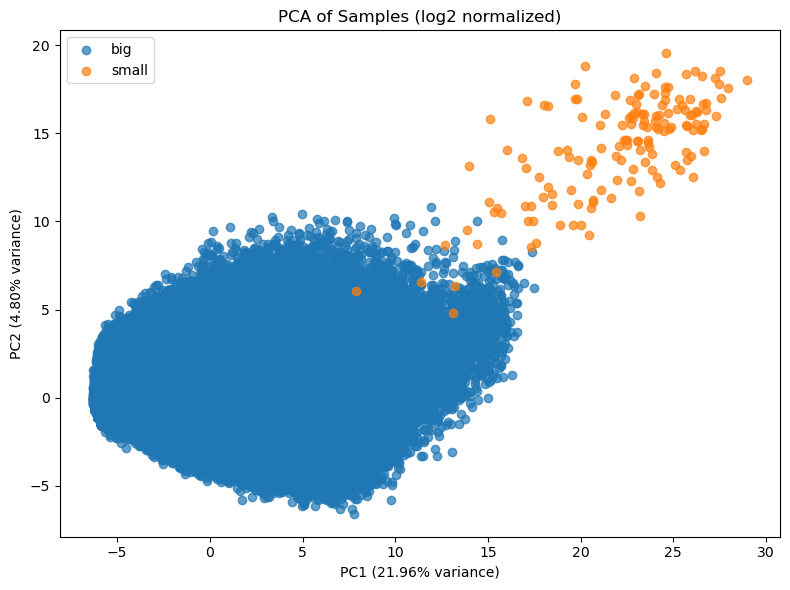

In [7]:
# Fit PCA on 'big', apply to both
pca = PCA(n_components=2)
pca.fit(big_scaled)
pca_big = pca.transform(big_scaled)
pca_small = pca.transform(small_scaled)

# Variance explained
pc1_var = pca.explained_variance_ratio_[0] * 100
pc2_var = pca.explained_variance_ratio_[1] * 100

# Plot
plt.figure(figsize=(8,6))
plt.scatter(pca_big[:, 0], pca_big[:, 1], label='big', alpha=0.7)
plt.scatter(pca_small[:, 0], pca_small[:, 1], label='small', alpha=0.7)
plt.xlabel(f'PC1 ({pc1_var:.2f}% variance)')
plt.ylabel(f'PC2 ({pc2_var:.2f}% variance)')
plt.title('PCA of Samples (log2 normalized)')
plt.legend()
plt.tight_layout()
plt.show()


In [8]:
#now draw a umap with log transformed data, but only show small data in the plot
import umap.umap_ as umap

# Keep sample IDs
big_samples = big_log.index.tolist()
small_samples = small_log.index.tolist()

# Standardize
scaler = StandardScaler()
big_scaled = scaler.fit_transform(big_log)
small_scaled = scaler.transform(small_log)

# Combine for UMAP
combined_scaled = np.vstack([big_scaled, small_scaled])
combined_samples = big_samples + small_samples
group_labels = ['big'] * len(big_samples) + ['small'] * len(small_samples)

# Run UMAP on combined data
umap_model = umap.UMAP(n_components=2, random_state=42)
umap_embedded = umap_model.fit_transform(combined_scaled)

# Create a dataframe
df_umap = pd.DataFrame(umap_embedded, columns=['UMAP1', 'UMAP2'])
df_umap['sample'] = combined_samples
df_umap['group'] = group_labels

# --- Now, only keep small group for plotting ---
df_small_umap = df_umap[df_umap['group'] == 'small']

# Plot only small samples, but in the same UMAP space
plt.figure(figsize=(8,6))
plt.scatter(df_small_umap['UMAP1'], df_small_umap['UMAP2'], label='small', alpha=0.8)
plt.title('UMAP: Small Samples Only')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.legend()
plt.tight_layout()
plt.show()

2025-10-13 03:07:17.066444: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-13 03:07:18.816085: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-13 03:07:22.614003: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-10-13 03:07:22.614048: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-10-13 03:07:22.989728: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

KeyboardInterrupt: 

In [ ]:
# Plot only small samples, but in the same UMAP space
plt.figure(figsize=(8,6))
plt.scatter(df_small_umap['UMAP1'], df_small_umap['UMAP2'], label='small', alpha=0.1)
plt.title('UMAP: Small Samples Only')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Plot UMAP with all samples
plt.figure(figsize=(8,6))
for grp in df_umap['group'].unique():
    subset = df_umap[df_umap['group'] == grp]
    plt.scatter(subset['UMAP1'], subset['UMAP2'], label=grp, alpha=0.7)
plt.title('UMAP of Samples')
plt.legend()
plt.tight_layout()
plt.show()

In [8]:
print(df_umap['group'].value_counts())

group
big      168464
small       154
Name: count, dtype: int64


In [9]:
print("Number of samples in big_log:", big_log.shape[0])    # rows = samples after transpose
print("Number of samples in small_log:", small_log.shape[0])

Number of samples in big_log: 168464
Number of samples in small_log: 154


In [10]:
print("Number of samples in big dataset:", big.shape[1])    # columns = samples
print("Number of samples in small dataset:", small.shape[1])

Number of samples in big dataset: 168464
Number of samples in small dataset: 154


In [14]:
print(df_umap.shape[0])  # Should match 154
print(df_umap['UMAP1'].min(), df_umap['UMAP1'].max())
print(df_umap['UMAP2'].min(), df_umap['UMAP2'].max())
print(small.shape[1])

168618
-6.289545059204102 26.287858963012695
-13.862076759338379 15.678669929504395
154


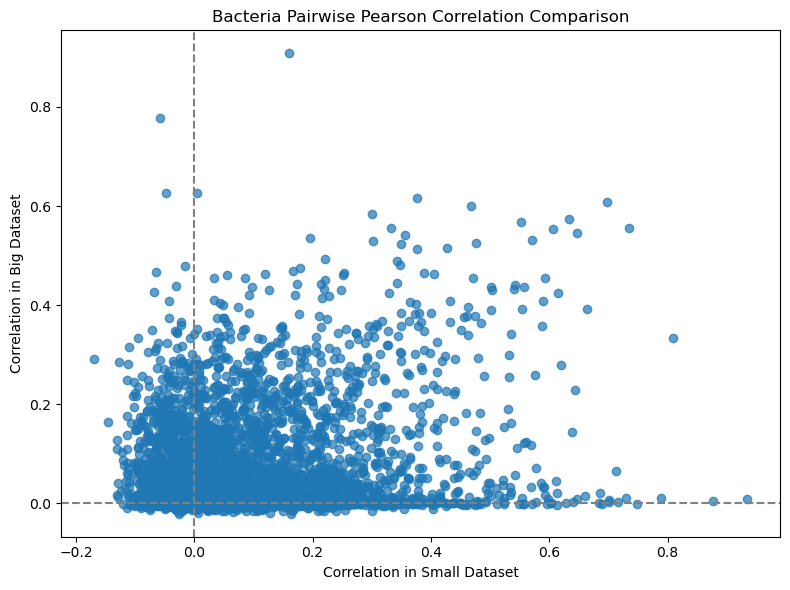

In [8]:
# Bacteria Pairwise Correlation Comparison

import itertools

# - big: bacteria (rows) × samples (columns)
# - small: same format (bacteria × samples)

# Step 1: Make sure both datasets have the same bacteria
common_bacteria = big.index.intersection(small.index)

big_common = big.loc[common_bacteria]
small_common = small.loc[common_bacteria]

# Step 2: Transpose (so samples are rows, bacteria are columns)
big_common_T = big_common.T
small_common_T = small_common.T

# Step 3: Compute pairwise correlations
# Each column is a bacteria, so we compute correlation between columns
corr_big = big_common_T.corr()
corr_small = small_common_T.corr()

# Step 4: Extract all unique bacteria pairs (upper triangle of the correlation matrix)
bacteria_pairs = list(itertools.combinations(common_bacteria, 2))

# Step 5: Prepare x and y values
x_vals = []
y_vals = []

for bac1, bac2 in bacteria_pairs:
    x_vals.append(corr_small.loc[bac1, bac2])
    y_vals.append(corr_big.loc[bac1, bac2])

# Step 6: Scatter plot
plt.figure(figsize=(8,6))
plt.scatter(x_vals, y_vals, alpha=0.7)
plt.xlabel('Correlation in Small Dataset')
plt.ylabel('Correlation in Big Dataset')
plt.title('Bacteria Pairwise Pearson Correlation Comparison')
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()


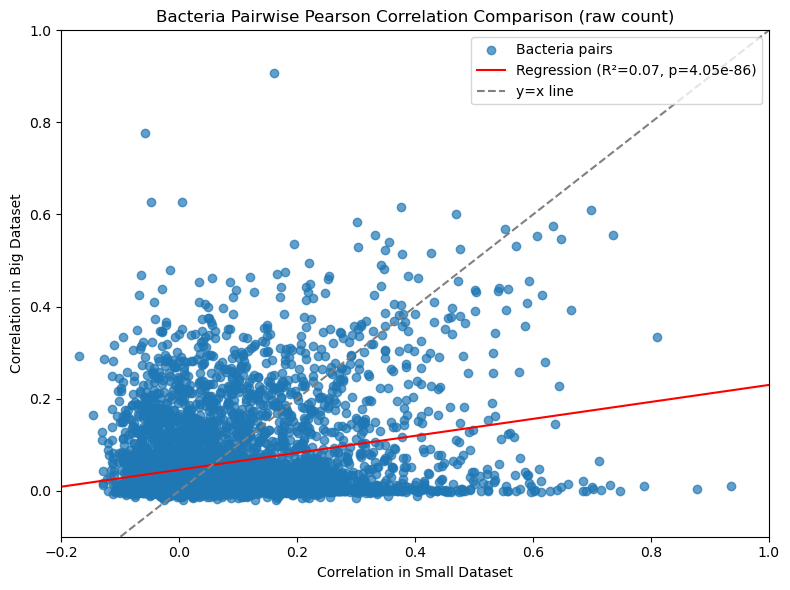

In [9]:
# add regression line

from scipy.stats import linregress

# Suppose x_vals and y_vals are already defined
x_array = np.array(x_vals)
y_array = np.array(y_vals)

# Fit linear regression with scipy
slope, intercept, r_value, p_value, std_err = linregress(x_array, y_array)

# Predict y for plotting regression line
x_fit = np.linspace(-1, 1, 100)
y_fit = slope * x_fit + intercept

# Scatter plot
plt.figure(figsize=(8,6))
plt.scatter(x_array, y_array, alpha=0.7, label='Bacteria pairs')

# Plot regression line
plt.plot(x_fit, y_fit, color='red', label=f'Regression (R²={r_value**2:.2f}, p={p_value:.2e})')

# Plot y=x identity line
plt.plot([-1, 1], [-1, 1], color='gray', linestyle='--', label='y=x line')

# Labels and title
plt.xlabel('Correlation in Small Dataset')
plt.ylabel('Correlation in Big Dataset')
plt.title('Bacteria Pairwise Pearson Correlation Comparison (raw count)')
plt.legend()
plt.xlim(-0.2, 1)
plt.ylim(-0.1, 1)
plt.tight_layout()
plt.savefig("/ix/hpark/Jie/LMM/Figure/Fig4A_part1.pdf", format="pdf")
plt.show()


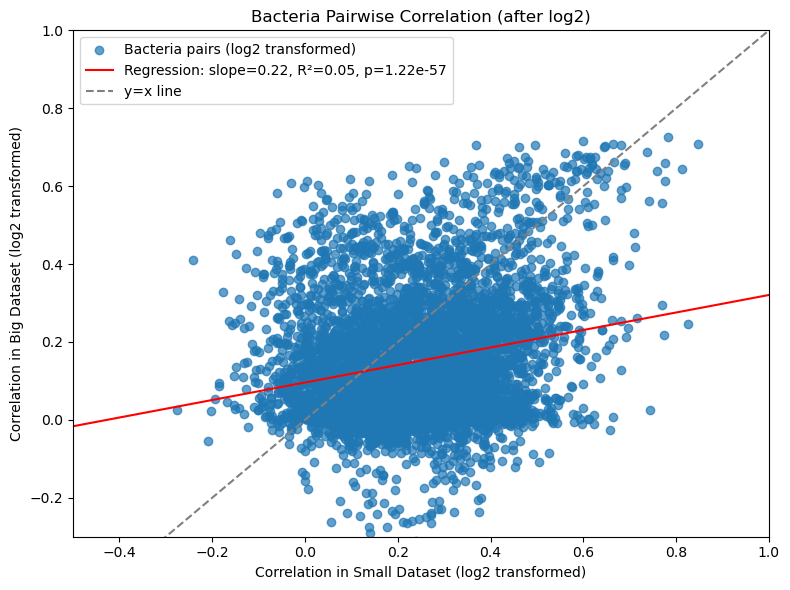

In [10]:
# Bacteria Pairwise Correlation Comparison using log2

# Step 1: Log2 transform
big_log = np.log2(big + 1e-6)
small_log = np.log2(small + 1e-6)

# Step 2: Find common bacteria
common_bacteria = big_log.index.intersection(small_log.index)

# Step 3: Subset to common bacteria
big_common_log = big_log.loc[common_bacteria]
small_common_log = small_log.loc[common_bacteria]

# Step 4: Transpose so samples are rows
big_common_log_T = big_common_log.T
small_common_log_T = small_common_log.T

# Step 5: Correlation matrices
corr_big_log = big_common_log_T.corr()
corr_small_log = small_common_log_T.corr()

# Step 6: Get all bacteria pairs
bacteria_pairs = list(itertools.combinations(common_bacteria, 2))

# Step 7: Extract correlation values
x_vals = []
y_vals = []

for bac1, bac2 in bacteria_pairs:
    x_vals.append(corr_small_log.loc[bac1, bac2])
    y_vals.append(corr_big_log.loc[bac1, bac2])

x_array = np.array(x_vals)
y_array = np.array(y_vals)

# Step 8: Linear regression
slope, intercept, r_value, p_value, std_err = linregress(x_array, y_array)

# Predict line
x_fit = np.linspace(-1, 1, 100)
y_fit = slope * x_fit + intercept

# Step 9: Scatter plot
plt.figure(figsize=(8,6))
plt.scatter(x_array, y_array, alpha=0.7, label='Bacteria pairs (log2 transformed)')

# Regression line
plt.plot(x_fit, y_fit, color='red', label=f'Regression: slope={slope:.2f}, R²={r_value**2:.2f}, p={p_value:.2e}'
)

# y = x identity line
plt.plot([-1, 1], [-1, 1], color='gray', linestyle='--', label='y=x line')

# Labels and title
plt.xlabel('Correlation in Small Dataset (log2 transformed)')
plt.ylabel('Correlation in Big Dataset (log2 transformed)')
plt.title('Bacteria Pairwise Correlation (after log2)')
plt.legend()
plt.xlim(-0.5, 1)
plt.ylim(-0.3, 1)
plt.tight_layout()
plt.savefig("/ix/hpark/Jie/LMM/Figure/Fig4A_part2.pdf", format="pdf")
plt.show()

In [11]:
# Load metadata for big and small datasets
meta_big = pd.read_csv("/ix/hpark/Jie/LMM/bigData_meta_country.csv")
meta_small = pd.read_csv("/ix/hpark/Jie/LMM/smallData_meta_country.csv")

In [5]:
print(meta_big.iloc[:6,])

   Unnamed: 0                sample age     geo_loc_name country       city  \
0           1  PRJDB10485_DRR243823  50  ghana:koforidua   ghana  koforidua   
1           2  PRJDB10485_DRR243824  52  ghana:koforidua   ghana  koforidua   
2           3  PRJDB10485_DRR243825  45  ghana:koforidua   ghana  koforidua   
3           4  PRJDB10485_DRR243826  43  ghana:koforidua   ghana  koforidua   
4           5  PRJDB10485_DRR243827  55  ghana:koforidua   ghana  koforidua   
5           6  PRJDB10485_DRR243828  57  ghana:koforidua   ghana  koforidua   

      sex  
0    male  
1    male  
2  female  
3  female  
4    male  
5    male  


In [6]:
print(meta_small.iloc[:10,])

   Unnamed: 0                       Sample Study_Clin_Response       Study  \
0           1   PD1SS17052dna201907dbDec22           Responder  Pittsburgh   
1           2   PD117Pittsdna201907dbDec22           Responder  Pittsburgh   
2           3   PD1SS17005dna201907dbDec22           Responder  Pittsburgh   
3           4   PD1TPF1820dna201907dbDec22           Responder  Pittsburgh   
4           5   PD118Pittsdna201907dbDec22           Responder  Pittsburgh   
5           6  PD1TPF17183dna201907dbDec22           Responder  Pittsburgh   
6           7     PD117006dna201907dbDec22           Responder  Pittsburgh   
7           8  PD1TPF17188dna201907dbDec22           Responder  Pittsburgh   
8           9     PD117001dna201907dbDec22           Responder  Pittsburgh   
9          10   PD128Pittsdna201907dbDec22       Non_Responder  Pittsburgh   

               clean_id     Sex                 Age  
0   PD1SS17052dna201907  Female  35.591780821917801  
1   PD117Pittsdna201907  Female  

In [12]:
# Rename columns in meta_big to match meta_small
meta_big_renamed = meta_big.rename(columns={
    'sample': 'Sample',
    'sex': 'Sex',
    'age': 'Age',
    'country': 'Country'
})

# add "country" column to small dataset
meta_small['Country'] = 'usa'

# (Optional) Add a group label
meta_big_renamed['group'] = 'big'
meta_small['group'] = 'small'

metadata = pd.concat([meta_big_renamed, meta_small], ignore_index=True)

print(metadata.iloc[:6, :10])

   Unnamed: 0                Sample Age     geo_loc_name Country       city  \
0           1  PRJDB10485_DRR243823  50  ghana:koforidua   ghana  koforidua   
1           2  PRJDB10485_DRR243824  52  ghana:koforidua   ghana  koforidua   
2           3  PRJDB10485_DRR243825  45  ghana:koforidua   ghana  koforidua   
3           4  PRJDB10485_DRR243826  43  ghana:koforidua   ghana  koforidua   
4           5  PRJDB10485_DRR243827  55  ghana:koforidua   ghana  koforidua   
5           6  PRJDB10485_DRR243828  57  ghana:koforidua   ghana  koforidua   

      Sex group Study_Clin_Response Study  
0    male   big                 NaN   NaN  
1    male   big                 NaN   NaN  
2  female   big                 NaN   NaN  
3  female   big                 NaN   NaN  
4    male   big                 NaN   NaN  
5    male   big                 NaN   NaN  


In [13]:
# Convert age to numeric
metadata['Age'] = pd.to_numeric(metadata['Age'], errors='coerce')

# Compute median age from combined metadata
median_age = metadata['Age'].median()

# Define subset logic
subset_filters = {
    "All": lambda df: pd.Series([True] * len(df), index=df.index),
    "USA": lambda df: df['Country'].fillna('').str.lower() == 'usa',
    "Female": lambda df: df['Sex'].fillna('').str.lower() == 'female',
    "Male": lambda df: df['Sex'].fillna('').str.lower() == 'male',
    "Young (< median age)": lambda df: pd.to_numeric(df['Age'], errors='coerce') < median_age,
    "Old (≥ median age)": lambda df: pd.to_numeric(df['Age'], errors='coerce') >= median_age
}

In [9]:
print(metadata.iloc[:6, :10])

   Unnamed: 0                Sample   Age     geo_loc_name Country       city  \
0           1  PRJDB10485_DRR243823  50.0  ghana:koforidua   ghana  koforidua   
1           2  PRJDB10485_DRR243824  52.0  ghana:koforidua   ghana  koforidua   
2           3  PRJDB10485_DRR243825  45.0  ghana:koforidua   ghana  koforidua   
3           4  PRJDB10485_DRR243826  43.0  ghana:koforidua   ghana  koforidua   
4           5  PRJDB10485_DRR243827  55.0  ghana:koforidua   ghana  koforidua   
5           6  PRJDB10485_DRR243828  57.0  ghana:koforidua   ghana  koforidua   

      Sex group Study_Clin_Response Study  
0    male   big                 NaN   NaN  
1    male   big                 NaN   NaN  
2  female   big                 NaN   NaN  
3  female   big                 NaN   NaN  
4    male   big                 NaN   NaN  
5    male   big                 NaN   NaN  


In [10]:
print(median_age)

47.0


In [14]:
# get the list of RA bacteria
highlight_bacteria = {
    "Alistipes", "Bacteroides", "Blautia", "Clostridium",
    "Parabacteroides", "Ruminococcus", "Anaerotruncus", "Clostridioides",
    "Lachnoclostridium", "Coprococcus", "Enterocloster", "Faecalibacterium",
    "Flavonifractor", "Fusicatenibacter", "Klebsiella", "Phascolarctobacterium",
    "Mediterraneibacter", "Ruthenibacterium"
}

All: 154 small samples, 168464 big samples


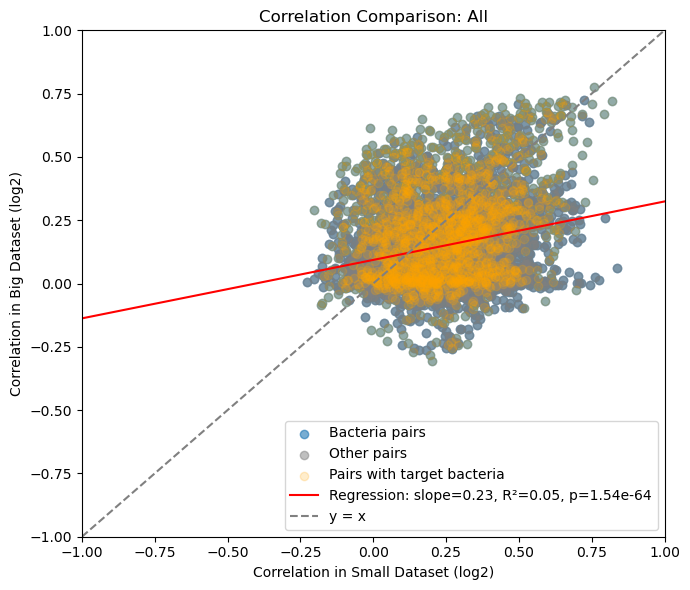

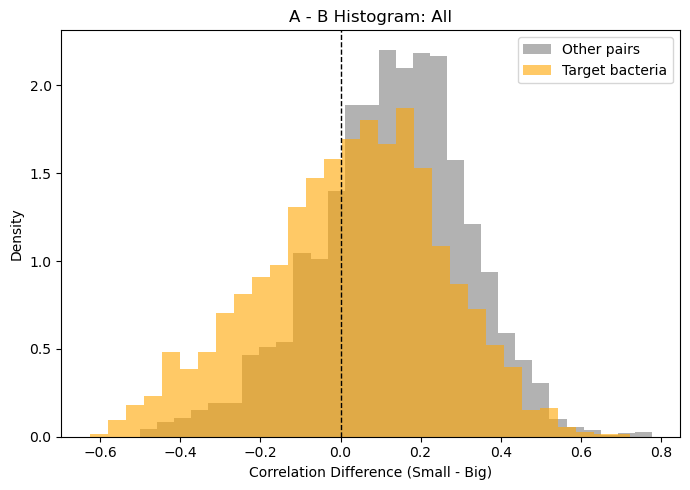

USA: 154 small samples, 59994 big samples


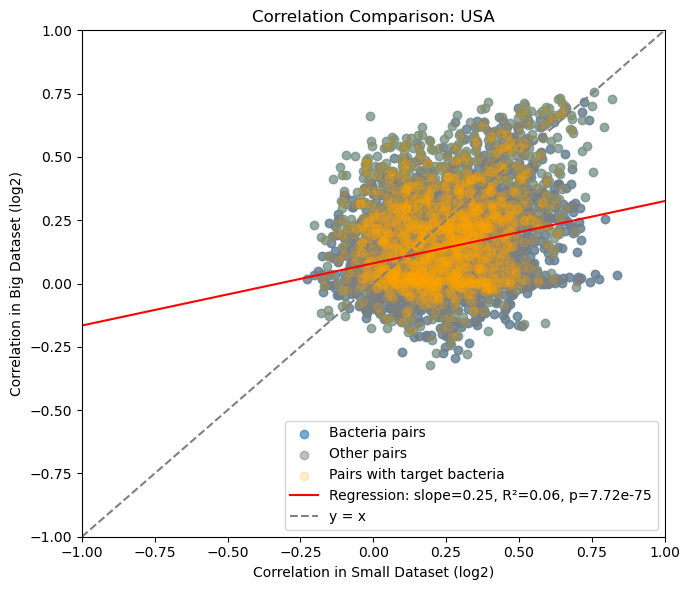

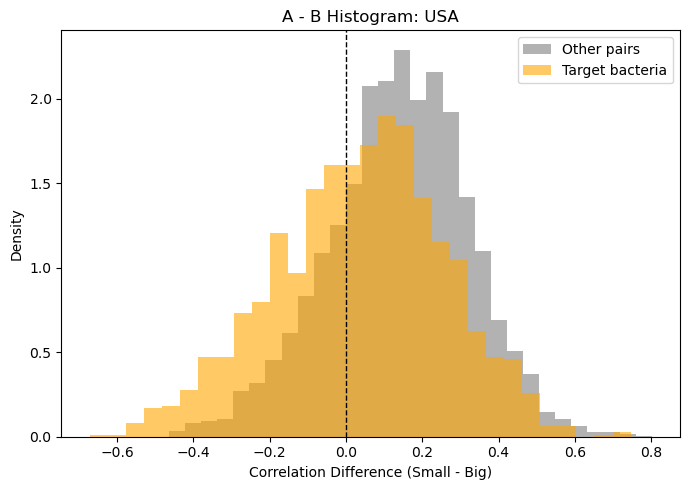

Female: 33 small samples, 10055 big samples


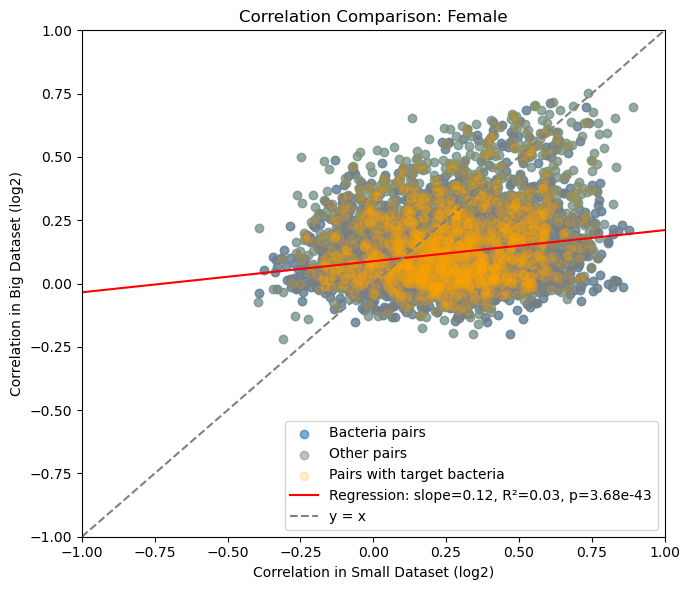

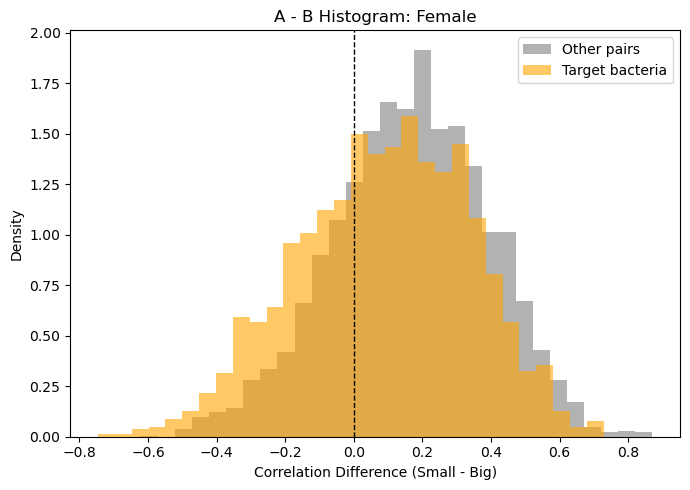

Male: 68 small samples, 9296 big samples


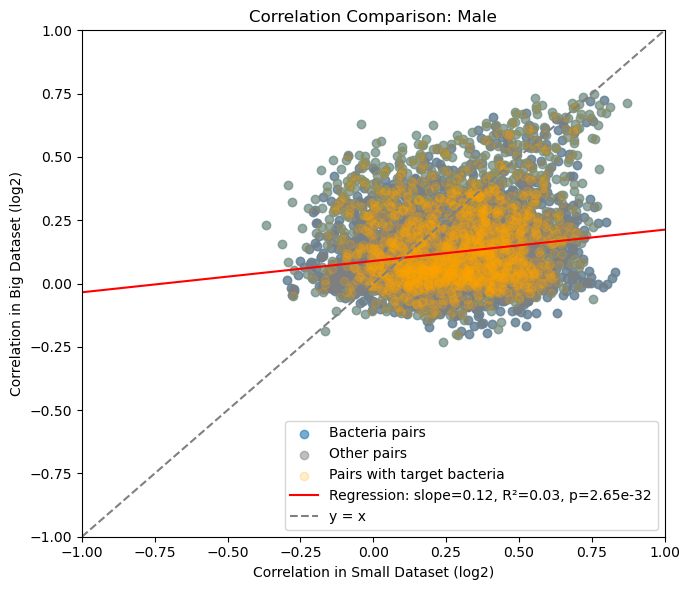

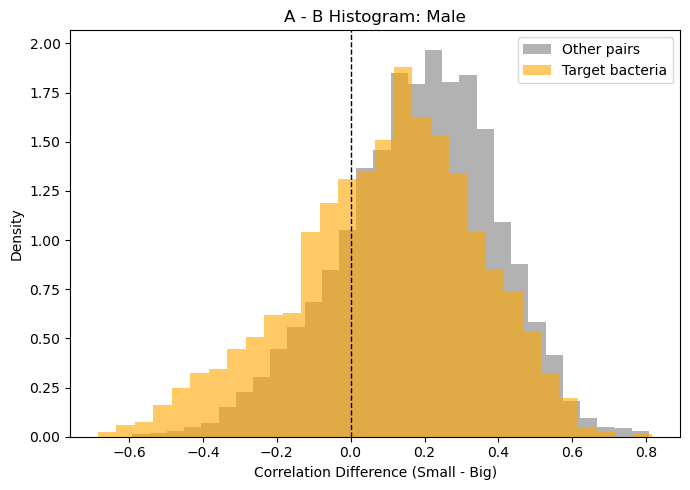

Young (< median age): 7 small samples, 8183 big samples


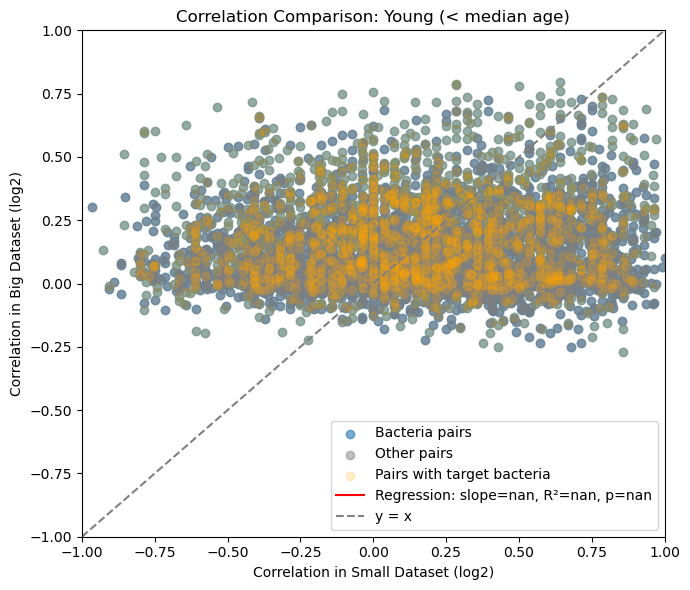

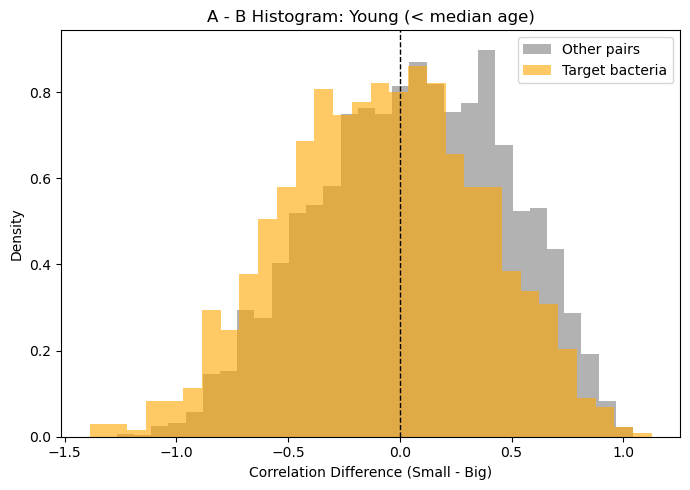

Old (≥ median age): 107 small samples, 8419 big samples


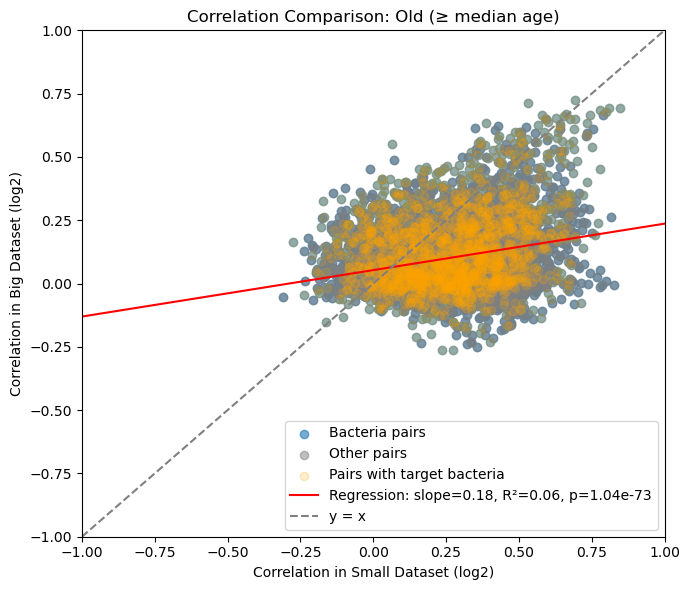

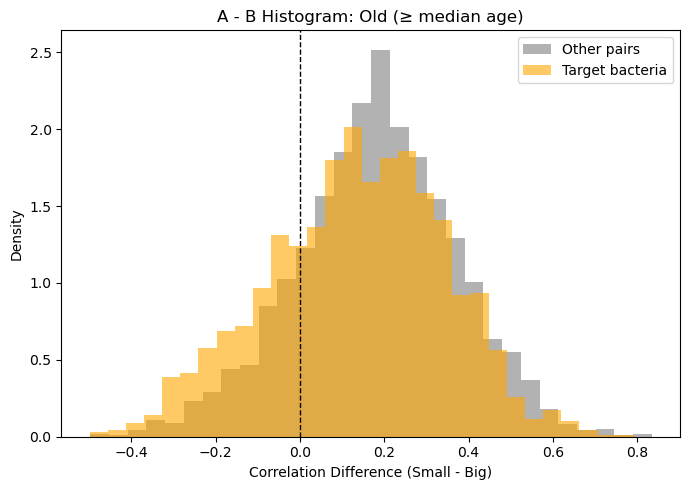

In [15]:
# Loop over each subset
slope_dict = {}

for label, condition in subset_filters.items():
    # Apply condition
    meta_sub_big = meta_big_renamed[condition(meta_big_renamed)]
    meta_sub_small = meta_small[condition(meta_small)]

    # Print sample counts
    print(f"{label}: {len(meta_sub_small)} small samples, {len(meta_sub_big)} big samples")

    # Subset abundance data using column (sample) names
    sub_big = big.loc[:, big.columns.intersection(meta_sub_big['Sample'])]
    sub_small = small.loc[:, small.columns.intersection(meta_sub_small['Sample'])]


    # Log2 transform
    sub_big_log = np.log2(sub_big + 1e-6)
    sub_small_log = np.log2(sub_small + 1e-6)

    # Find common bacteria
    common_bacteria = sub_big_log.index.intersection(sub_small_log.index)
    if len(common_bacteria) < 2:
        print(f"  Skipped: Not enough common bacteria.")
        continue

    # Transpose for correlation
    big_corr = sub_big_log.loc[common_bacteria].T.corr(method='spearman')
    small_corr = sub_small_log.loc[common_bacteria].T.corr(method='spearman')

    # Collect correlation pairs
    from itertools import combinations
    x_vals, y_vals, highlight_flags = [], [], []
    for bac1, bac2 in combinations(common_bacteria, 2):
        x_vals.append(small_corr.loc[bac1, bac2])
        y_vals.append(big_corr.loc[bac1, bac2])
        # mark True if either bacteria is in the set
        highlight_flags.append(bac1 in highlight_bacteria or bac2 in highlight_bacteria)

    if len(x_vals) < 5:
        print(f"  Skipped: Not enough bacteria pairs ({len(x_vals)})")
        continue

    # Linear regression
    from scipy.stats import linregress
    x_array = np.array(x_vals)
    y_array = np.array(y_vals)
    highlight_flags = np.array(highlight_flags)
    slope, intercept, r_value, p_value, _ = linregress(x_array, y_array)

    x_fit = np.linspace(-1, 1, 100)
    y_fit = slope * x_fit + intercept
    
    slope_dict[label] = slope

    # Plot
    plt.figure(figsize=(7,6))
    #plt.scatter(x_array, y_array, alpha=0.6, label='Bacteria pairs') # the original plotting without highlighting RA
    # Plot regular points
    plt.scatter(x_array[~highlight_flags], y_array[~highlight_flags], 
            alpha=0.5, label='Other pairs', color='gray')

    # Plot highlighted points
    plt.scatter(x_array[highlight_flags], y_array[highlight_flags], 
            alpha=0.2, label='Pairs with target bacteria', color='orange')
    plt.plot(x_fit, y_fit, color='red',
             label=f'Regression: slope={slope:.2f}, R²={r_value**2:.2f}, p={p_value:.2e}')
    plt.plot([-1, 1], [-1, 1], color='gray', linestyle='--', label='y = x')
    plt.xlabel('Correlation in Small Dataset (log2)')
    plt.ylabel('Correlation in Big Dataset (log2)')
    plt.title(f'Correlation Comparison: {label}')
    plt.legend()
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.tight_layout()
    #plt.savefig(f"/ix/hpark/Jie/LMM/Figure/scatter_{label}.pdf")
    plt.show()
    
    # Compute A - B (x - y)
    diffs_highlighted = x_array[highlight_flags] - y_array[highlight_flags]
    diffs_other = x_array[~highlight_flags] - y_array[~highlight_flags]

    # Histogram
    plt.figure(figsize=(7, 5))
    plt.hist(diffs_other, bins=30, alpha=0.6, label='Other pairs', color='gray', density=True)
    plt.hist(diffs_highlighted, bins=30, alpha=0.6, label='Target bacteria', color='orange', density=True)

    plt.axvline(0, color='black', linestyle='--', linewidth=1)
    plt.xlabel('Correlation Difference (Small - Big)')
    plt.ylabel('Density')
    plt.title(f'A - B Histogram: {label}')
    plt.legend()
    plt.tight_layout()
    #plt.savefig(f"/ix/hpark/Jie/LMM/Figure/histogram_diff_{label}.pdf")
    plt.show()



===== Responders only =====

All: 80 small samples, 168464 big samples


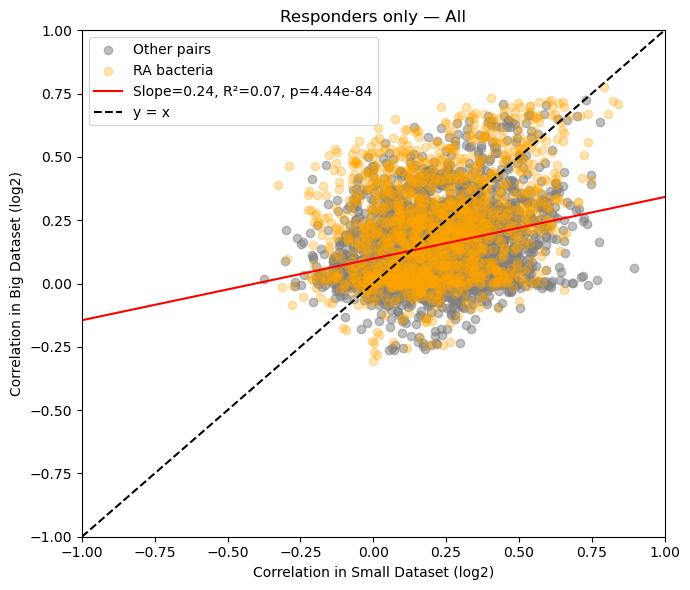

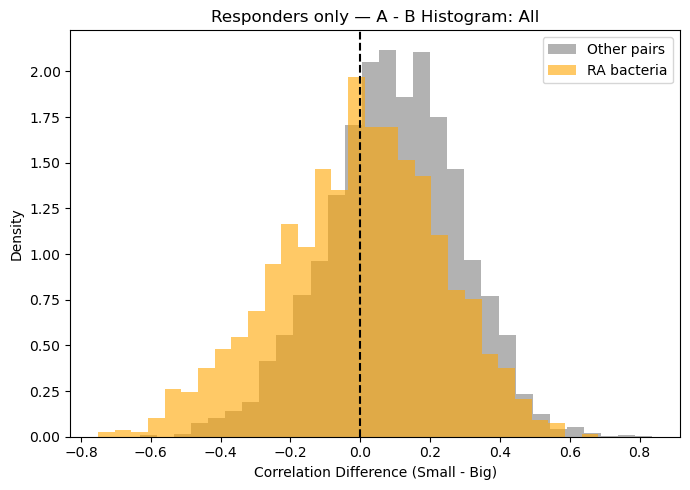

USA: 80 small samples, 59994 big samples


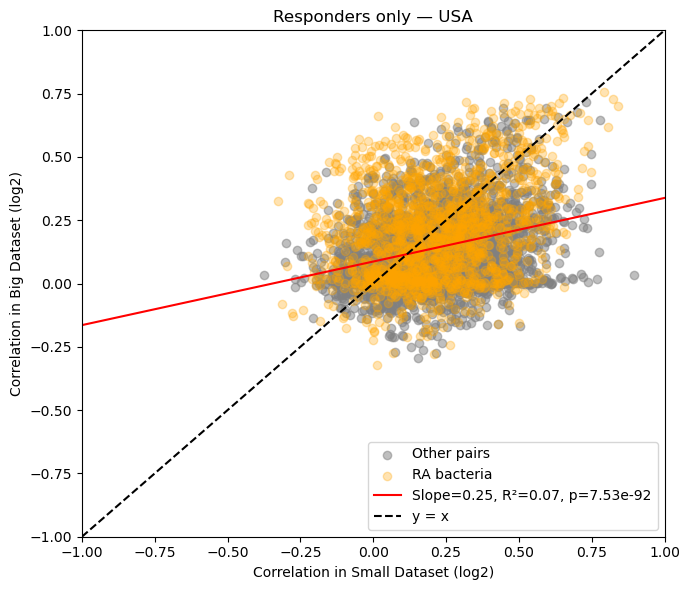

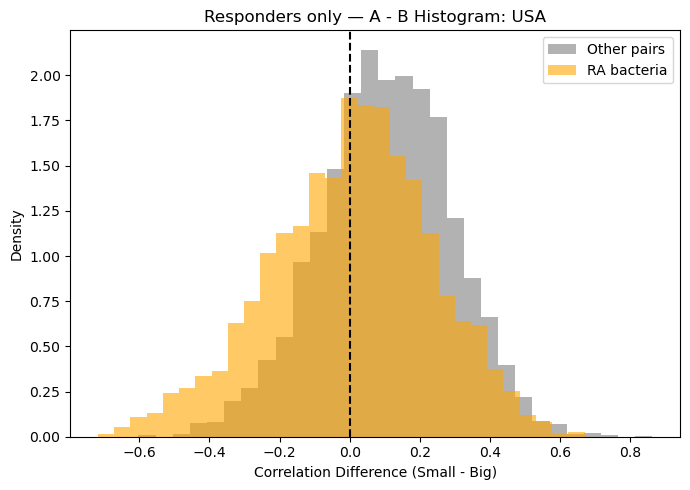

Female: 22 small samples, 10055 big samples


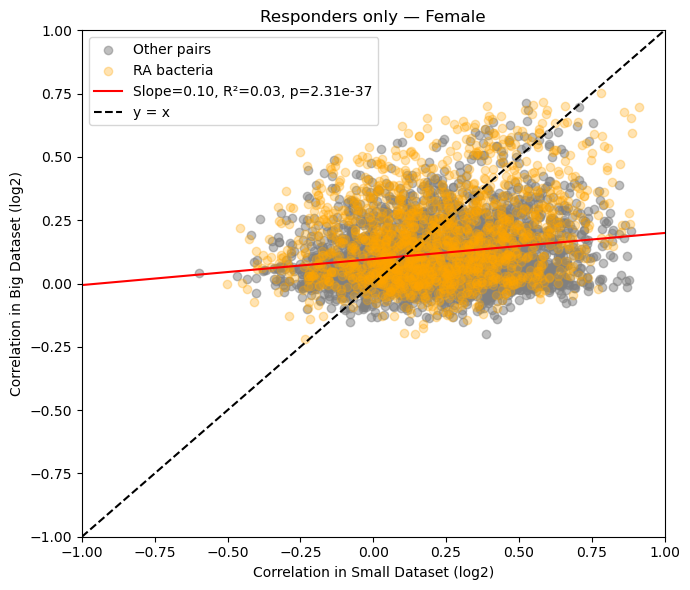

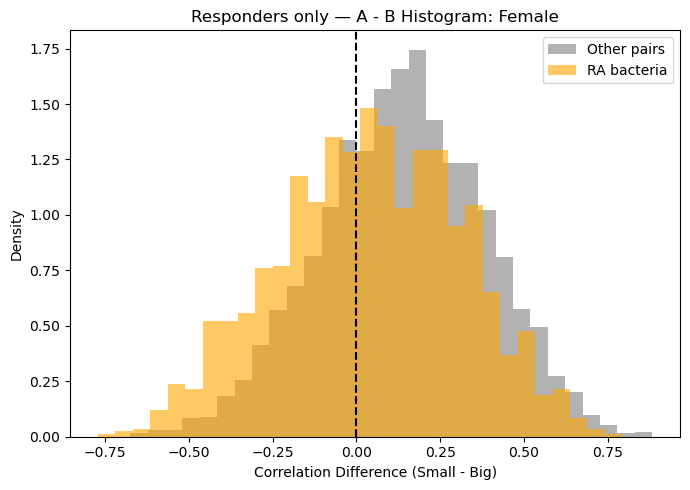

Male: 36 small samples, 9296 big samples


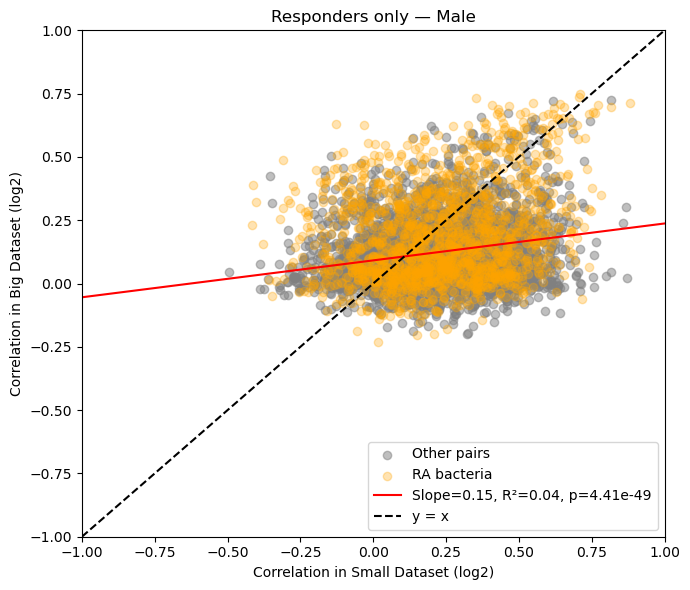

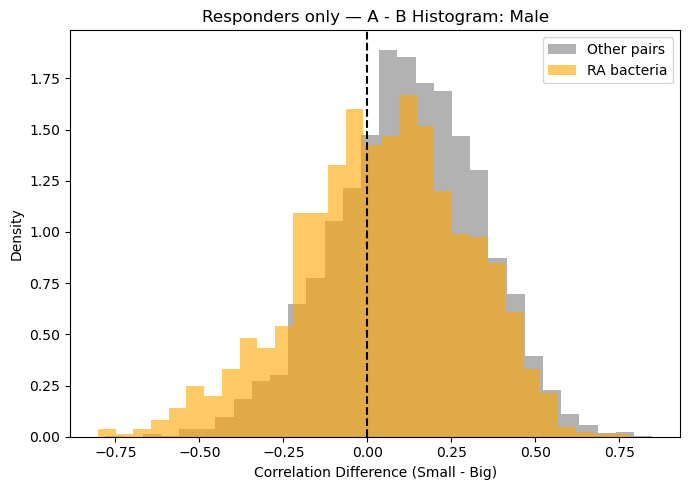

Young (< median age): 5 small samples, 8183 big samples


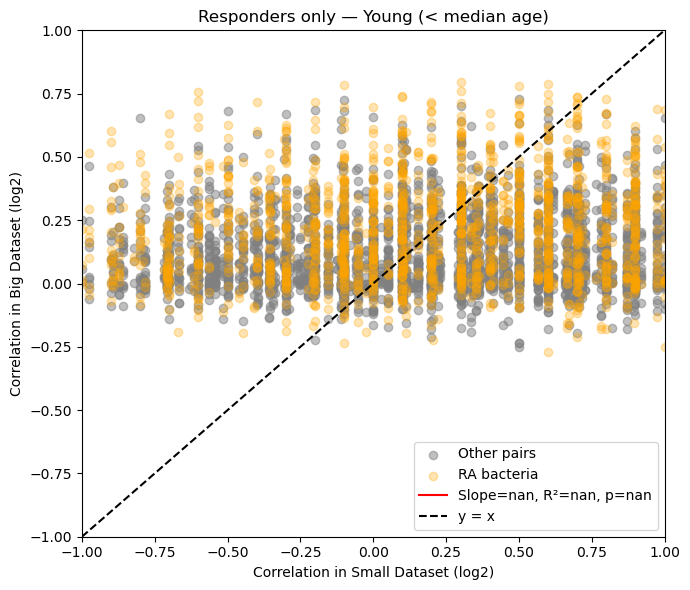

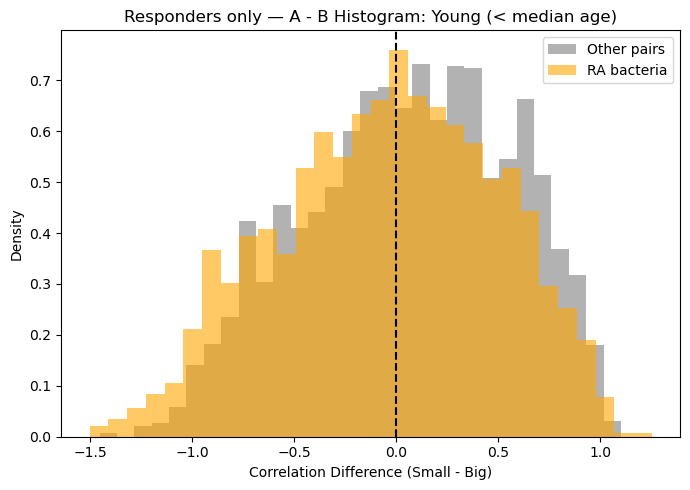

Old (≥ median age): 59 small samples, 8419 big samples


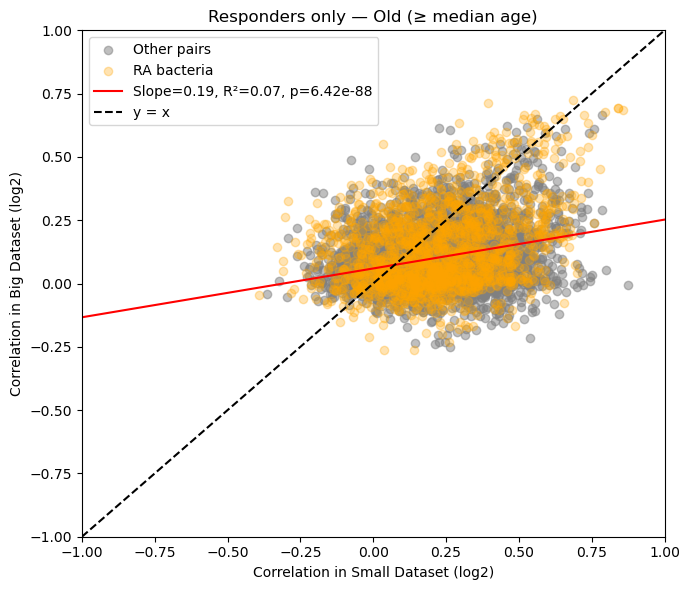

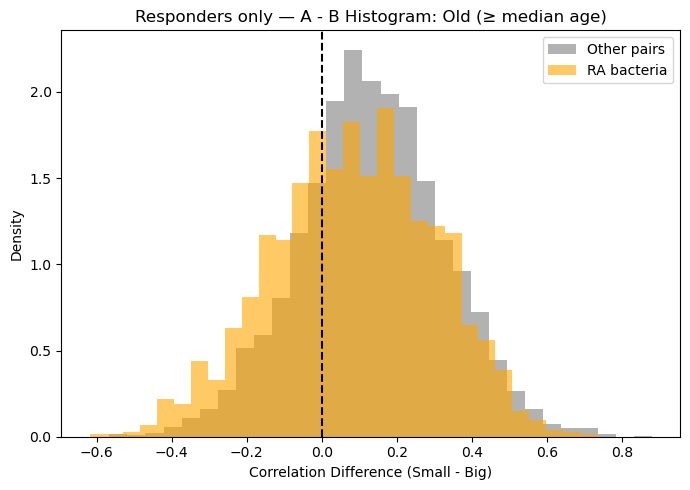


===== Non-Responders only =====

All: 74 small samples, 168464 big samples


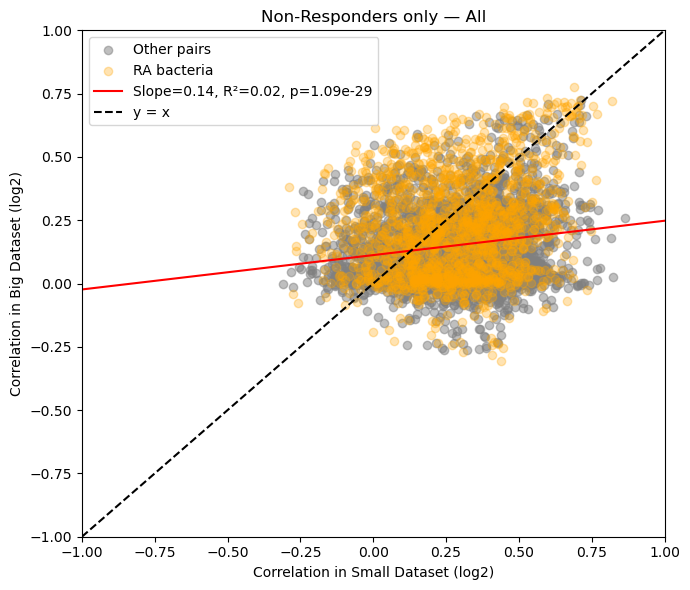

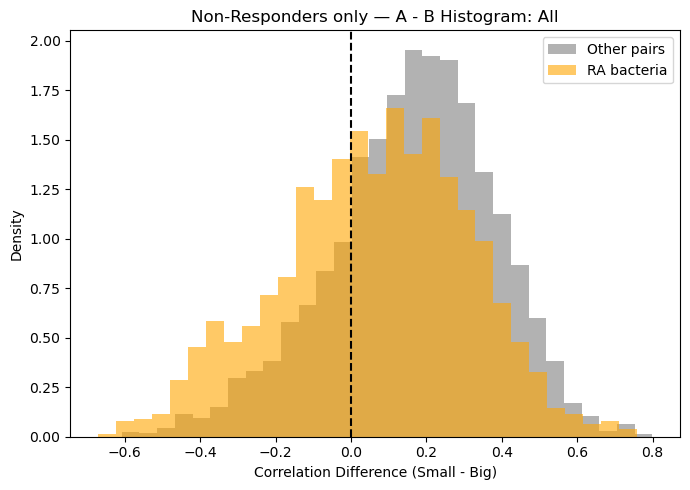

USA: 74 small samples, 59994 big samples


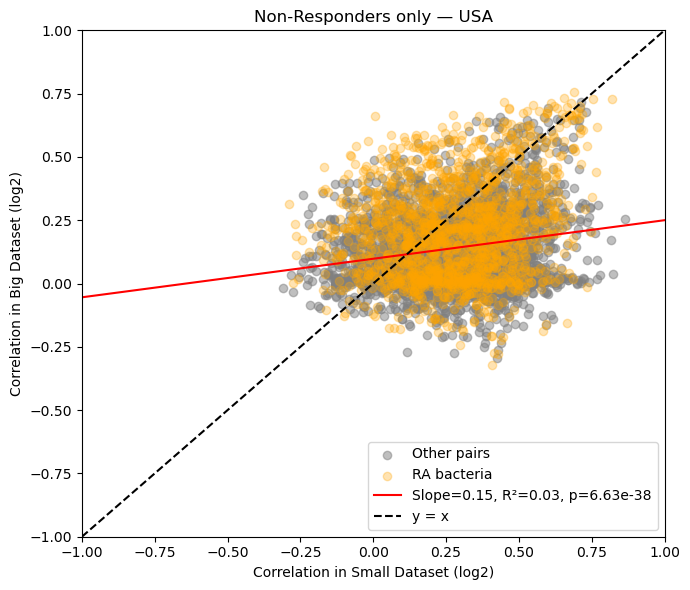

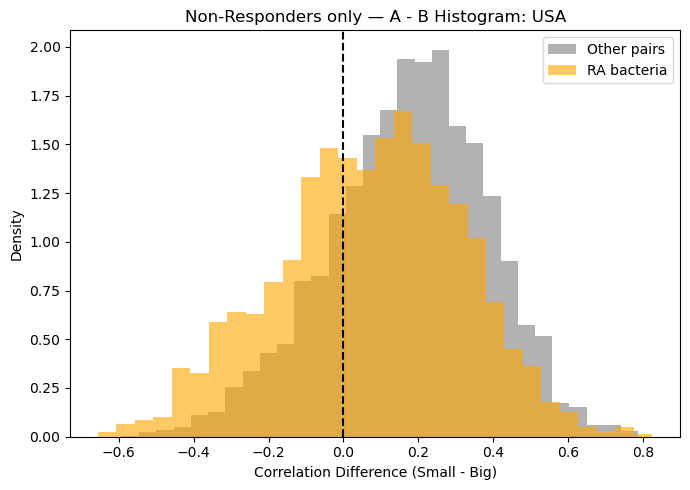

Female: 11 small samples, 10055 big samples


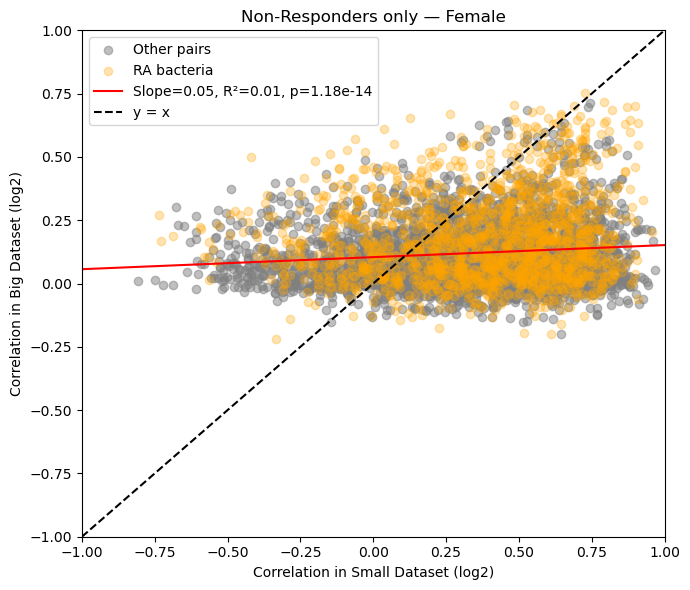

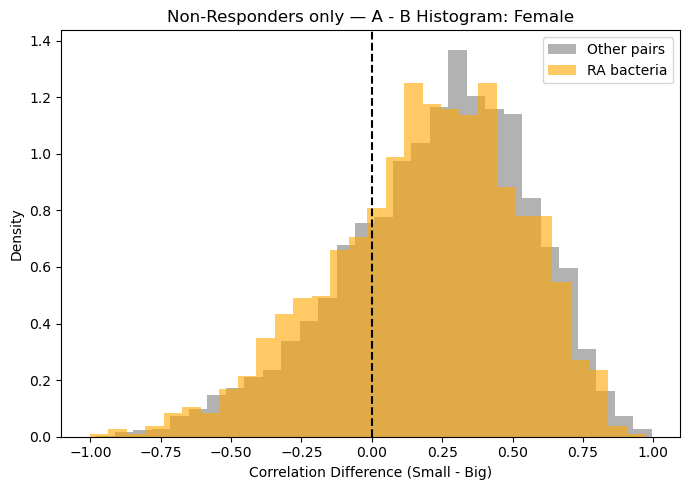

Male: 32 small samples, 9296 big samples


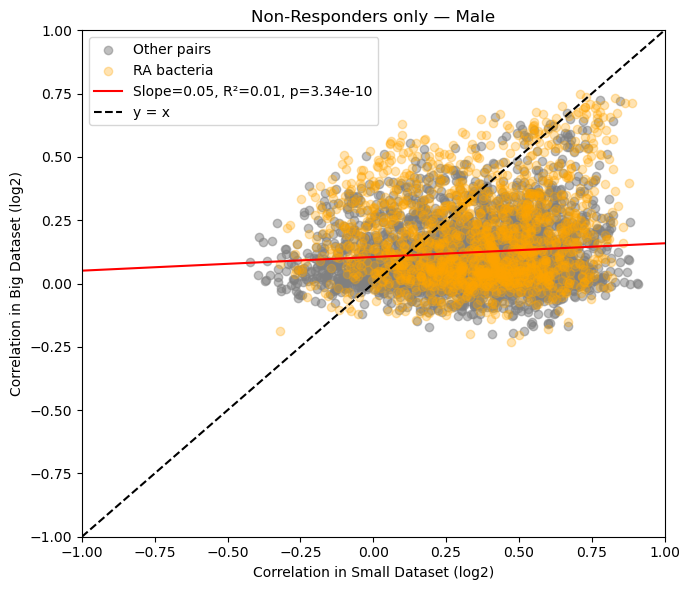

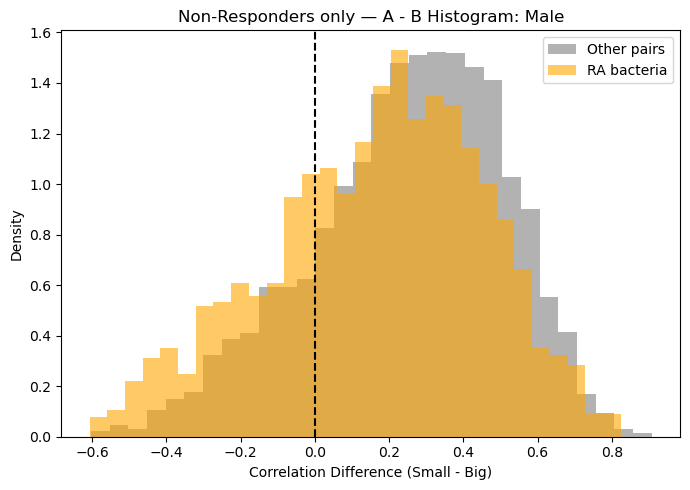

Young (< median age): 2 small samples, 8183 big samples


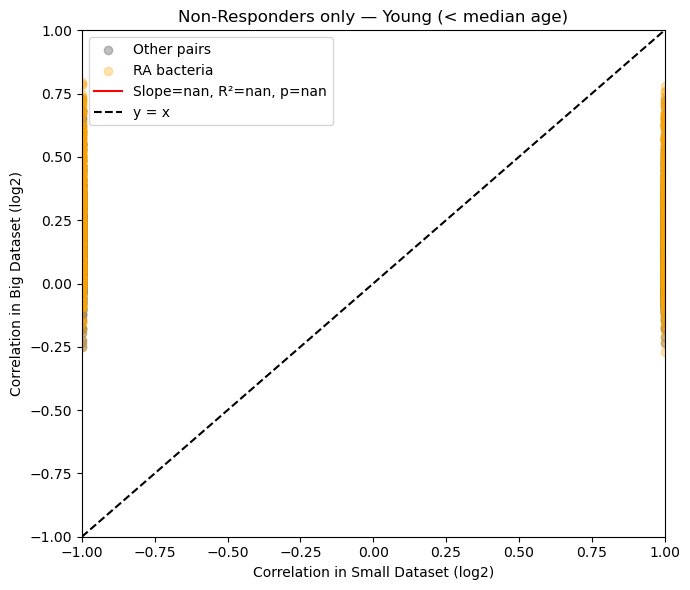

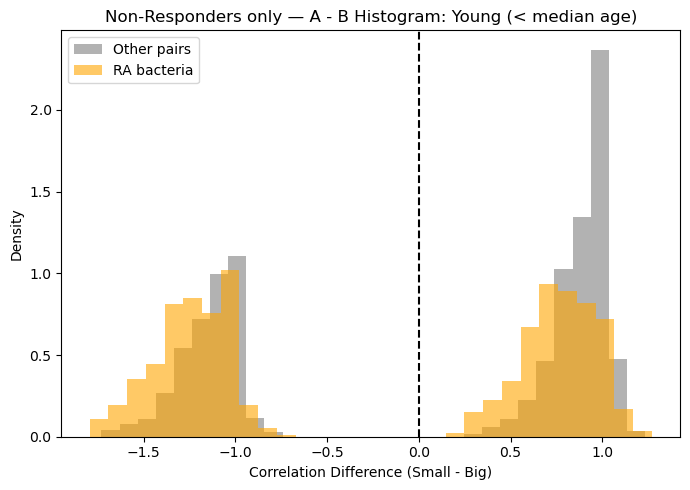

Old (≥ median age): 48 small samples, 8419 big samples


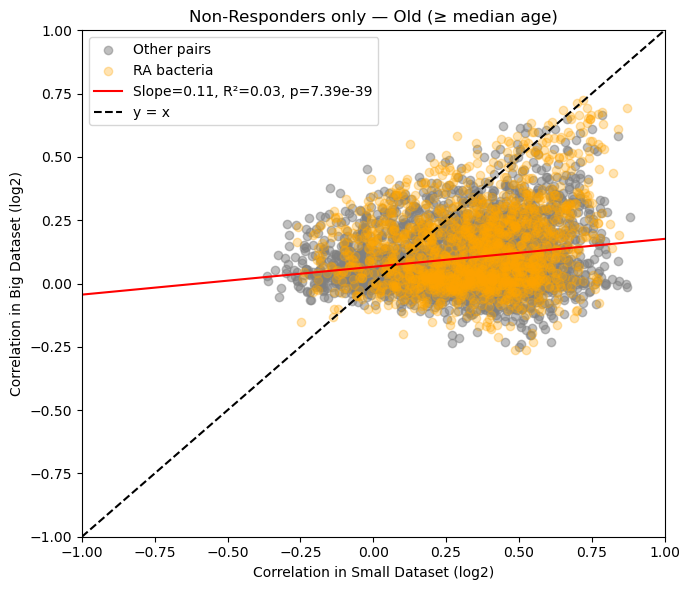

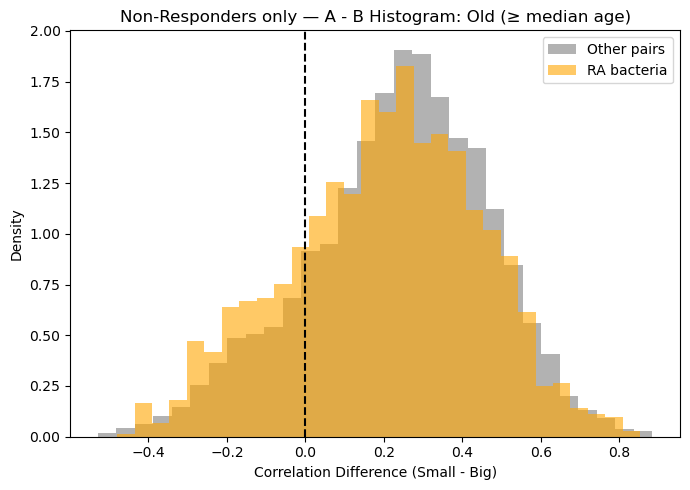

In [17]:
# now using Rs and NRs in small dataset only, re-draw the plots above

response_groups = {
    "Responders only": "responder",
    "Non-Responders only": "non_responder"
}

# Loop over responder / non-responder
for response_label, response_value in response_groups.items():
    print(f"\n===== {response_label} =====\n")

    # Subset small metadata and abundance matrix
    meta_small_subset = meta_small[meta_small['Study_Clin_Response'].str.strip().str.lower() == response_value]
    small_subset = small.loc[:, small.columns.intersection(meta_small_subset['Sample'])]

    # Loop over each condition within the response group
    for label, condition in subset_filters.items():
        # Apply condition
        meta_sub_big = meta_big_renamed[condition(meta_big_renamed)]
        meta_sub_small = meta_small_subset[condition(meta_small_subset)]

        # Print sample counts
        print(f"{label}: {len(meta_sub_small)} small samples, {len(meta_sub_big)} big samples")

        # Subset abundance data using sample IDs
        sub_big = big.loc[:, big.columns.intersection(meta_sub_big['Sample'])]
        sub_small = small_subset.loc[:, small_subset.columns.intersection(meta_sub_small['Sample'])]

        # Log transform
        sub_big_log = np.log2(sub_big + 1e-6)
        sub_small_log = np.log2(sub_small + 1e-6)

        # Common bacteria
        common_bacteria = sub_big_log.index.intersection(sub_small_log.index)
        if len(common_bacteria) < 2:
            print("  Skipped: Not enough common bacteria.")
            continue

        # Correlations
        big_corr = sub_big_log.loc[common_bacteria].T.corr(method='spearman')
        small_corr = sub_small_log.loc[common_bacteria].T.corr(method='spearman')

        from itertools import combinations
        x_vals, y_vals, highlight_flags = [], [], []
        for bac1, bac2 in combinations(common_bacteria, 2):
            x_vals.append(small_corr.loc[bac1, bac2])
            y_vals.append(big_corr.loc[bac1, bac2])
            highlight_flags.append(
                bac1 in highlight_bacteria or bac2 in highlight_bacteria
            )

        if len(x_vals) < 5:
            print("  Skipped: Not enough bacteria pairs.")
            continue

        # Regression
        from scipy.stats import linregress
        x_array = np.array(x_vals)
        y_array = np.array(y_vals)
        highlight_flags = np.array(highlight_flags, dtype=bool)

        slope, intercept, r_value, p_value, _ = linregress(x_array, y_array)

        x_fit = np.linspace(-1, 1, 100)
        y_fit = slope * x_fit + intercept

        # Scatter Plot
        plt.figure(figsize=(7, 6))
        plt.scatter(x_array[~highlight_flags], y_array[~highlight_flags], alpha=0.5, label='Other pairs', color='gray')
        plt.scatter(x_array[highlight_flags], y_array[highlight_flags], alpha=0.3, label='RA bacteria', color='orange')
        plt.plot(x_fit, y_fit, color='red', label=f'Slope={slope:.2f}, R²={r_value**2:.2f}, p={p_value:.2e}')
        plt.plot([-1, 1], [-1, 1], linestyle='--', color='black', label='y = x')
        plt.xlabel('Correlation in Small Dataset (log2)')
        plt.ylabel('Correlation in Big Dataset (log2)')
        plt.title(f'{response_label} — {label}')
        plt.legend()
        plt.xlim(-1, 1)
        plt.ylim(-1, 1)
        plt.tight_layout()
        plt.show()

        # A - B Histogram
        diffs_highlighted = x_array[highlight_flags] - y_array[highlight_flags]
        diffs_other = x_array[~highlight_flags] - y_array[~highlight_flags]

        plt.figure(figsize=(7, 5))
        plt.hist(diffs_other, bins=30, alpha=0.6, label='Other pairs', color='gray', density=True)
        plt.hist(diffs_highlighted, bins=30, alpha=0.6, label='RA bacteria', color='orange', density=True)
        plt.axvline(0, linestyle='--', color='black')
        plt.xlabel('Correlation Difference (Small - Big)')
        plt.ylabel('Density')
        plt.title(f'{response_label} — A - B Histogram: {label}')
        plt.legend()
        plt.tight_layout()
        plt.savefig(f"/ix/hpark/Jie/LMM/Figure/Res_histogram_diff_{response_label}_{label}.pdf")
        plt.show()


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


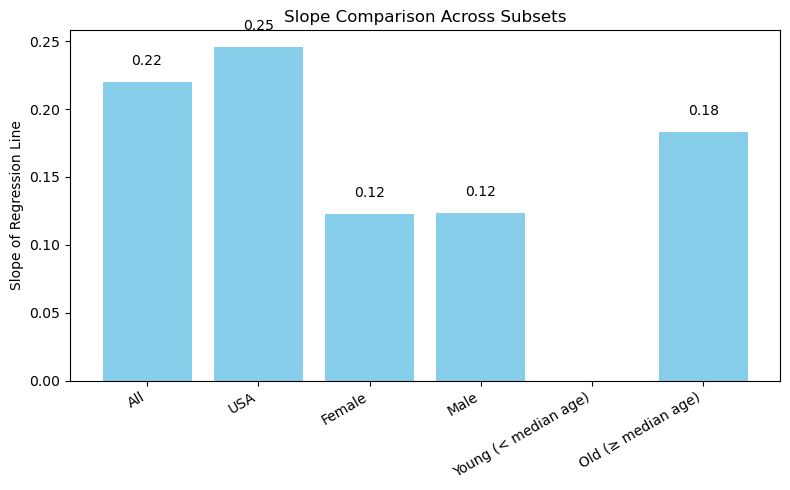

In [22]:
# Add the overall slope manually
slope_dict["All"] = 0.22  # or the actual computed overall slope

# Optional: sort bars (optional but looks nice)
#sorted_slope_dict = dict(sorted(slope_dict.items(), key=lambda item: item[1], reverse=True))

# Create bar plot
plt.figure(figsize=(8, 5))
bars = plt.bar(slope_dict.keys(), slope_dict.values(), color='skyblue')

# Add value labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom')

# Axis labels and formatting
plt.ylabel('Slope of Regression Line')
plt.title('Slope Comparison Across Subsets')
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.savefig("/ix/hpark/Jie/LMM/Figure/Fig4C.pdf", format="pdf")
plt.show()

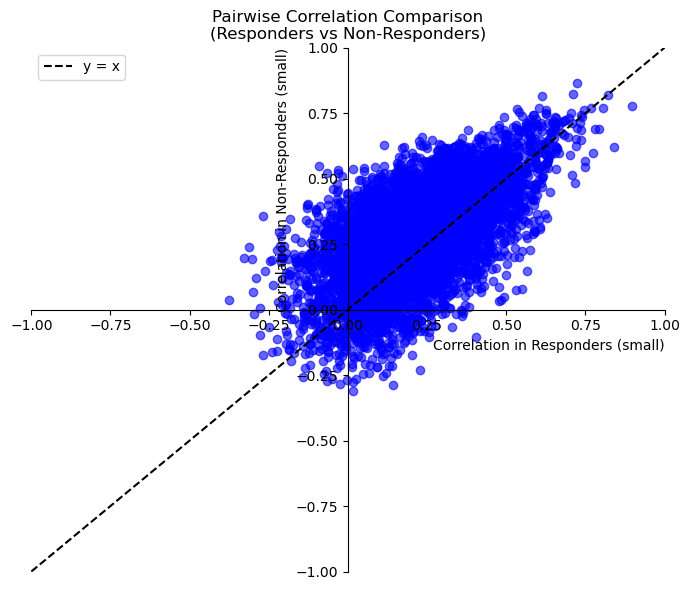

In [26]:
from itertools import combinations

# Log2 transform
small_log = np.log2(small + 1e-6)

# Find common bacteria
common_bacteria = big.index.intersection(small_log.index)

# Ensure response column is clean
meta_small['Study_Clin_Response'] = meta_small['Study_Clin_Response'].str.strip().str.lower()

# Sample IDs for each group
responder_ids = meta_small[meta_small['Study_Clin_Response'] == 'responder']['Sample']
nonresponder_ids = meta_small[meta_small['Study_Clin_Response'] == 'non_responder']['Sample']

# Filter abundance matrix by sample IDs
responder_abund = small_log.loc[common_bacteria, small_log.columns.intersection(responder_ids)]
nonresponder_abund = small_log.loc[common_bacteria, small_log.columns.intersection(nonresponder_ids)]

# Compute pairwise correlations
corr_responder = responder_abund.T.corr(method='spearman')
corr_nonresponder = nonresponder_abund.T.corr(method='spearman')

# Collect pairwise values
x_vals, y_vals = [], []
pair_names = []

for bac1, bac2 in combinations(common_bacteria, 2):
    if bac1 in corr_responder and bac2 in corr_responder:
        x = corr_responder.loc[bac1, bac2]
        y = corr_nonresponder.loc[bac1, bac2]
        x_vals.append(x)
        y_vals.append(y)
        pair_names.append(f"{bac1}–{bac2}")

# Plot
fig, ax = plt.subplots(figsize=(7, 6))
ax.scatter(x_vals, y_vals, alpha=0.6, color='blue')
ax.plot([-1, 1], [-1, 1], linestyle='--', color='black', label='y = x')

# Center axes at (0,0)
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

# Labels and formatting
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_xlabel('Correlation in Responders (small)', loc='right')
ax.set_ylabel('Correlation in Non-Responders (small)', loc='top')
ax.set_title('Pairwise Correlation Comparison\n(Responders vs Non-Responders)')
ax.legend()
plt.tight_layout()
plt.show()


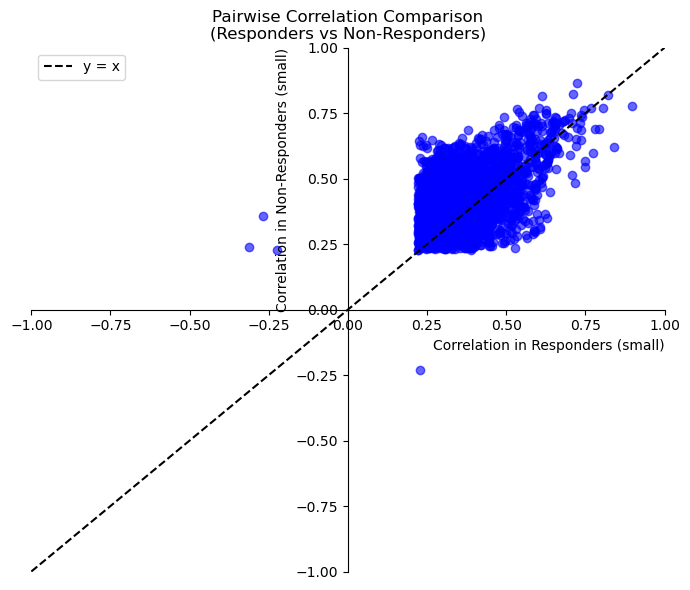

In [15]:
x_vals, y_vals, pair_names = [], [], []

for bac1, bac2 in combinations(common_bacteria, 2):
    # Abundance across samples
    r1 = responder_abund.loc[bac1]
    r2 = responder_abund.loc[bac2]
    nr1 = nonresponder_abund.loc[bac1]
    nr2 = nonresponder_abund.loc[bac2]

    # Spearman correlation
    rho_r, p_r = spearmanr(r1, r2)
    rho_nr, p_nr = spearmanr(nr1, nr2)

    if np.isfinite(rho_r) and np.isfinite(rho_nr) and p_r < 0.05 and p_nr < 0.05:
        x_vals.append(rho_r)
        y_vals.append(rho_nr)
        pair_names.append(f"{bac1}–{bac2}")

# Plot
fig, ax = plt.subplots(figsize=(7, 6))
ax.scatter(x_vals, y_vals, alpha=0.6, color='blue')
ax.plot([-1, 1], [-1, 1], linestyle='--', color='black', label='y = x')

# Center axes at (0,0)
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

# Labels and formatting
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_xlabel('Correlation in Responders (small)', loc='right')
ax.set_ylabel('Correlation in Non-Responders (small)', loc='top')
ax.set_title('Pairwise Correlation Comparison\n(Responders vs Non-Responders)')
ax.legend()
plt.tight_layout()
plt.show()

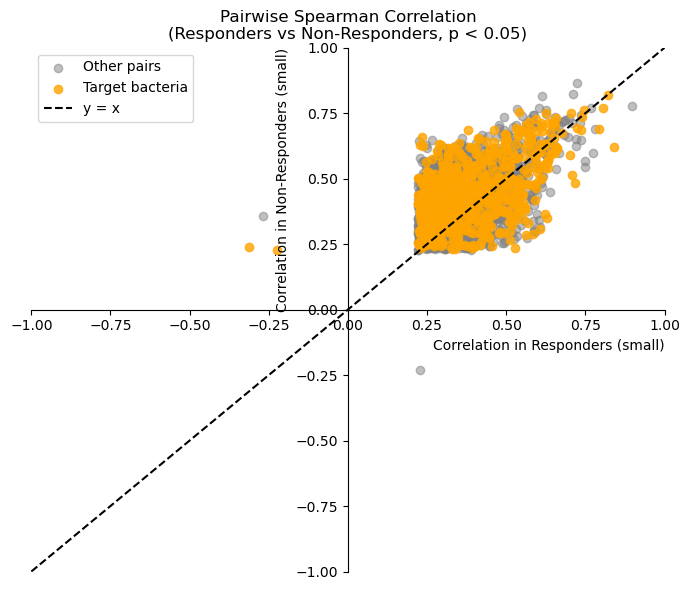

In [27]:
from itertools import combinations

# color the scatter plot with RA information
# --- Prepare highlight bacteria set ---
highlight_bacteria = {
    "Alistipes", "Bacteroides", "Blautia", "Clostridium",
    "Parabacteroides", "Ruminococcus", "Anaerotruncus", "Clostridioides",
    "Lachnoclostridium", "Coprococcus", "Enterocloster", "Faecalibacterium",
    "Flavonifractor", "Fusicatenibacter", "Klebsiella", "Phascolarctobacterium",
    "Mediterraneibacter", "Ruthenibacterium"
}
highlight_bacteria = {b.lower() for b in highlight_bacteria}

# Log2 transform
small_log = np.log2(small + 1e-6)

# Find common bacteria
common_bacteria = big.index.intersection(small_log.index)

# --- Sample filtering ---
meta_small['Study_Clin_Response'] = meta_small['Study_Clin_Response'].str.strip().str.lower()
responder_ids = meta_small[meta_small['Study_Clin_Response'] == 'responder']['Sample']
nonresponder_ids = meta_small[meta_small['Study_Clin_Response'] == 'non_responder']['Sample']

responder_abund = small_log.loc[common_bacteria, small_log.columns.intersection(responder_ids)]
nonresponder_abund = small_log.loc[common_bacteria, small_log.columns.intersection(nonresponder_ids)]

# --- Correlation loop with Spearman and highlight flag ---
x_vals, y_vals, highlight_flags = [], [], []

for bac1, bac2 in combinations(common_bacteria, 2):
    if bac1 in responder_abund.index and bac2 in responder_abund.index:
        r1 = responder_abund.loc[bac1]
        r2 = responder_abund.loc[bac2]
        nr1 = nonresponder_abund.loc[bac1]
        nr2 = nonresponder_abund.loc[bac2]

        rho_r, p_r = spearmanr(r1, r2)
        rho_nr, p_nr = spearmanr(nr1, nr2)

        if np.isfinite(rho_r) and np.isfinite(rho_nr) and p_r < 0.05 and p_nr < 0.05:
            x_vals.append(rho_r)
            y_vals.append(rho_nr)
            highlight_flags.append(bac1.lower() in highlight_bacteria or bac2.lower() in highlight_bacteria)

# --- Plot ---
x_array = np.array(x_vals)
y_array = np.array(y_vals)
highlight_flags = np.array(highlight_flags, dtype=bool)


fig, ax = plt.subplots(figsize=(7, 6))
ax.scatter(x_array[~highlight_flags], y_array[~highlight_flags], alpha=0.5, color='gray', label='Other pairs')
ax.scatter(x_array[highlight_flags], y_array[highlight_flags], alpha=0.8, color='orange', label='Target bacteria')

# Identity line
ax.plot([-1, 1], [-1, 1], linestyle='--', color='black', label='y = x')

# Center axes at (0,0)
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

# Labels
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_xlabel('Correlation in Responders (small)', loc='right')
ax.set_ylabel('Correlation in Non-Responders (small)', loc='top')
ax.set_title('Pairwise Spearman Correlation\n(Responders vs Non-Responders, p < 0.05)')
ax.legend()
plt.tight_layout()
plt.show()


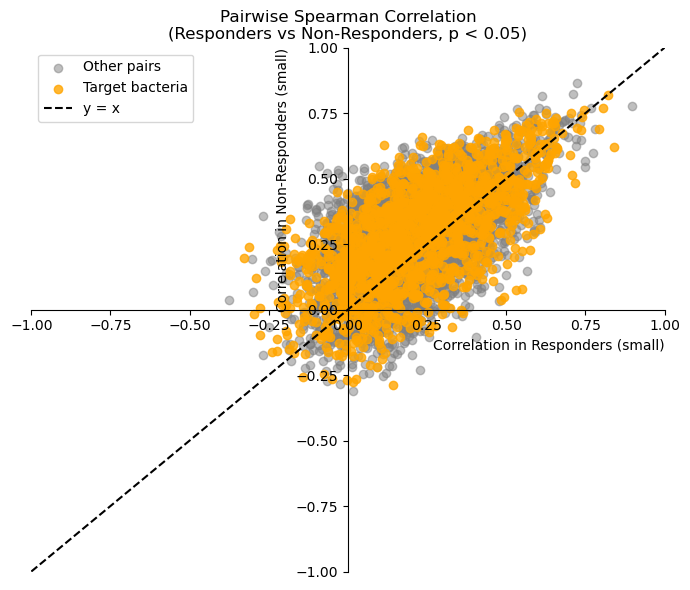

In [10]:
# --- Correlation loop with Spearman and no highlight flag ---
x_vals, y_vals, highlight_flags = [], [], []

for bac1, bac2 in combinations(common_bacteria, 2):
    if bac1 in responder_abund.index and bac2 in responder_abund.index:
        r1 = responder_abund.loc[bac1]
        r2 = responder_abund.loc[bac2]
        nr1 = nonresponder_abund.loc[bac1]
        nr2 = nonresponder_abund.loc[bac2]

        rho_r, _ = spearmanr(r1, r2)
        rho_nr, _ = spearmanr(nr1, nr2)

        if np.isfinite(rho_r) and np.isfinite(rho_nr):
            x_vals.append(rho_r)
            y_vals.append(rho_nr)
            highlight_flags.append(
                bac1.lower() in highlight_bacteria or bac2.lower() in highlight_bacteria
            )
# --- Plot ---
x_array = np.array(x_vals)
y_array = np.array(y_vals)
highlight_flags = np.array(highlight_flags, dtype=bool)


fig, ax = plt.subplots(figsize=(7, 6))
ax.scatter(x_array[~highlight_flags], y_array[~highlight_flags], alpha=0.5, color='gray', label='Other pairs')
ax.scatter(x_array[highlight_flags], y_array[highlight_flags], alpha=0.8, color='orange', label='Target bacteria')

# Identity line
ax.plot([-1, 1], [-1, 1], linestyle='--', color='black', label='y = x')

# Center axes at (0,0)
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

# Labels
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_xlabel('Correlation in Responders (small)', loc='right')
ax.set_ylabel('Correlation in Non-Responders (small)', loc='top')
ax.set_title('Pairwise Spearman Correlation\n(Responders vs Non-Responders, p < 0.05)')
ax.legend()
plt.tight_layout()
plt.show()

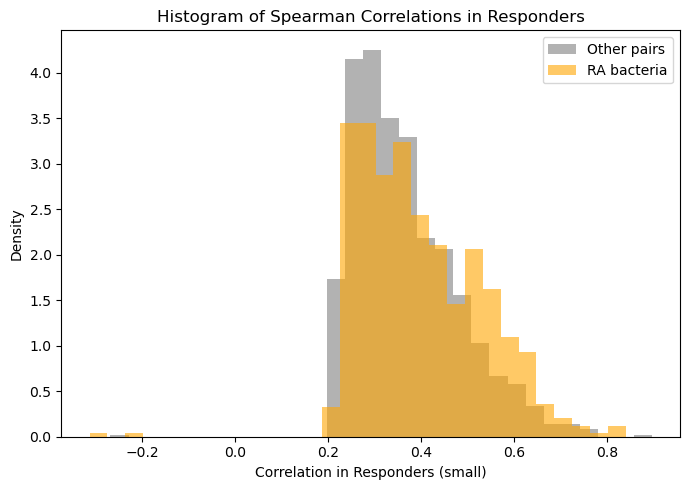

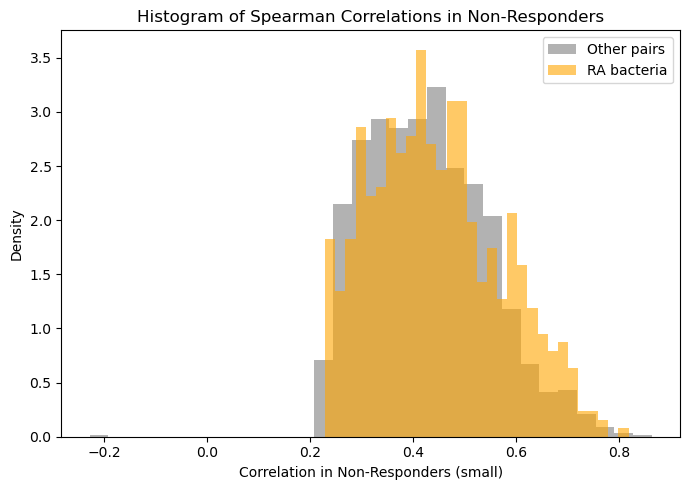

In [28]:
# draw histograms
# Histogram data split by group
x_array = np.array(x_vals)
y_array = np.array(y_vals)
highlight_flags = np.array(highlight_flags, dtype=bool)

# Plot histograms for Responders (x-axis correlations)
plt.figure(figsize=(7, 5))
plt.hist(x_array[~highlight_flags], bins=30, alpha=0.6, label='Other pairs', color='gray', density=True)
plt.hist(x_array[highlight_flags], bins=30, alpha=0.6, label='RA bacteria', color='orange', density=True)
plt.xlabel('Correlation in Responders (small)')
plt.ylabel('Density')
plt.title('Histogram of Spearman Correlations in Responders')
plt.legend()
plt.tight_layout()
plt.show()

# Plot histograms for Non-Responders (y-axis correlations)
plt.figure(figsize=(7, 5))
plt.hist(y_array[~highlight_flags], bins=30, alpha=0.6, label='Other pairs', color='gray', density=True)
plt.hist(y_array[highlight_flags], bins=30, alpha=0.6, label='RA bacteria', color='orange', density=True)
plt.xlabel('Correlation in Non-Responders (small)')
plt.ylabel('Density')
plt.title('Histogram of Spearman Correlations in Non-Responders')
plt.legend()
plt.tight_layout()
plt.show()


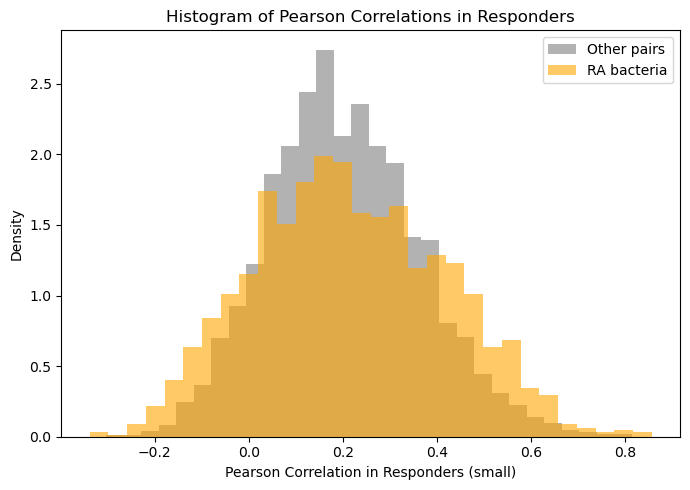

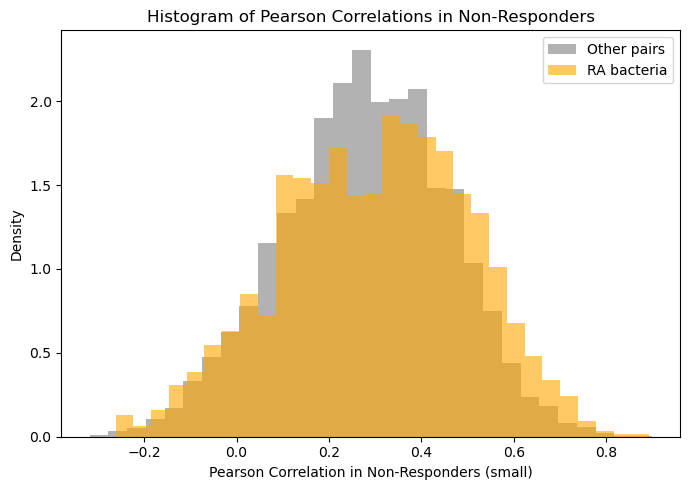

In [29]:
# draw histograms again in pearson's correlation
# --- Pearson correlation calculation ---
x_vals, y_vals, highlight_flags = [], [], []

for bac1, bac2 in combinations(common_bacteria, 2):
    if bac1 in responder_abund.index and bac2 in responder_abund.index:
        r1 = responder_abund.loc[bac1]
        r2 = responder_abund.loc[bac2]
        nr1 = nonresponder_abund.loc[bac1]
        nr2 = nonresponder_abund.loc[bac2]

        rho_r = np.corrcoef(r1, r2)[0, 1]
        rho_nr = np.corrcoef(nr1, nr2)[0, 1]

        if np.isfinite(rho_r) and np.isfinite(rho_nr):
            x_vals.append(rho_r)
            y_vals.append(rho_nr)
            highlight_flags.append(bac1.lower() in highlight_bacteria or bac2.lower() in highlight_bacteria)

# --- Convert to arrays
x_array = np.array(x_vals)
y_array = np.array(y_vals)
highlight_flags = np.array(highlight_flags, dtype=bool)

# --- Histogram: Responders
plt.figure(figsize=(7, 5))
plt.hist(x_array[~highlight_flags], bins=30, alpha=0.6, label='Other pairs', color='gray', density=True)
plt.hist(x_array[highlight_flags], bins=30, alpha=0.6, label='RA bacteria', color='orange', density=True)
plt.xlabel('Pearson Correlation in Responders (small)')
plt.ylabel('Density')
plt.title('Histogram of Pearson Correlations in Responders')
plt.legend()
plt.tight_layout()
plt.show()

# --- Histogram: Non-Responders
plt.figure(figsize=(7, 5))
plt.hist(y_array[~highlight_flags], bins=30, alpha=0.6, label='Other pairs', color='gray', density=True)
plt.hist(y_array[highlight_flags], bins=30, alpha=0.6, label='RA bacteria', color='orange', density=True)
plt.xlabel('Pearson Correlation in Non-Responders (small)')
plt.ylabel('Density')
plt.title('Histogram of Pearson Correlations in Non-Responders')
plt.legend()
plt.tight_layout()
plt.show()


In [10]:
print(f"Responder samples: {responder_abund.shape[1]}")
print(f"Non-responder samples: {nonresponder_abund.shape[1]}")

Responder samples: 0
Non-responder samples: 0


In [12]:
print(meta_small.iloc[:10, :10])

   Unnamed: 0                       Sample Study_Clin_Response       Study  \
0           1   PD1SS17052dna201907dbDec22           Responder  Pittsburgh   
1           2   PD117Pittsdna201907dbDec22           Responder  Pittsburgh   
2           3   PD1SS17005dna201907dbDec22           Responder  Pittsburgh   
3           4   PD1TPF1820dna201907dbDec22           Responder  Pittsburgh   
4           5   PD118Pittsdna201907dbDec22           Responder  Pittsburgh   
5           6  PD1TPF17183dna201907dbDec22           Responder  Pittsburgh   
6           7     PD117006dna201907dbDec22           Responder  Pittsburgh   
7           8  PD1TPF17188dna201907dbDec22           Responder  Pittsburgh   
8           9     PD117001dna201907dbDec22           Responder  Pittsburgh   
9          10   PD128Pittsdna201907dbDec22       Non_Responder  Pittsburgh   

               clean_id     Sex                 Age       Response  
0   PD1SS17052dna201907  Female  35.591780821917801      responder  
1  